## All my notes :


In this project, I've took advantage from these 
* [Part-1](https://youtu.be/hht0iKzviWE?si=xlIO_hD5z1QQ4Nrt) and
* [Part-2](https://youtu.be/CLHlGbu5YaI?si=6x9I1BJMcmI4q4AE) cover each steps and more. 

The majority of this notebook is from Part 1, but I have also included some code and more from Part 2. I did not follow the "HYPERPARAMETER TUNING AND BACKTESTING" instructions in Part 2. However, cross validation techniques were used without hyperparameters from Part 1. 

If you are confused, you can check out the sources or contact me. Also, please keep in mind that I am still learning, so if you spot any incorrect explanations or anything, please let me know. Enjoy your journey, as well.


In addition, I've added my personal comments and tried some different methods for reaching results.

You can reach sout my [notebook on kaggle](https://www.kaggle.com/code/muhammetipil/time-series-forecasting-with-prophet?scriptVersionId=182043647).

Also you can reach out my [github repository](https://github.com/muhammetcipil/Time_Series_Forecasting_With_Prophet).

---
In general, in this notebook, we've worked on the "store sales" dataset, which is sales data for the Ecuador retail brand. And the dataset includes different sheets. In this notebook, we focused on the train.csv dataset. The train.csv dataset includes id, date, store number, family (the main category for sales), sales (sales price), and onpromotion columns. Before training our model, we prepared our dataset for the Prophet model. Firstly, we grouped our data first by date, then we grouped second time for family (category). And as a last thing, we calculated the sum of each day's family sales.

And then we created a new pivot table for readability. Then we filtered our data into different datasets after 2015-08-15. Because of the clearer data.

For focusing on most volume families (categories), we split three datasets into low, mid, and high volume datasets.

And then we selected our target family from a high-volume dataset as a "product" category. Later on, we created a holiday dataset, which is getting holiday dates from the "holidays" library for ECUADOR. Before creating our model, The last thing we decided was to exclude the last 30 days as a test dataset. and determined the period to be 30 days.

We select the FACEOOK PROPHET model for our time series.
* determined period as 30 days.
* calculated model's MAPE.

Model evaluation with the cross-validation method.

# Content
* [Libraries](#chapter1)
* [Defining Required Functions](#chapter2)
* [Data Preprocessing](#chapter3)
    * [Remove low-volume(Average under 1000) columns](#chapter3.1)
    * [Removing Outlies ](#chapter3.2)
        * [Visualisation for seeing the changes and how they affected our data, removing outliers in general](#chapter3.2.1)
    * [Checking for missing values](#chapter3.3)
    * [Separating data in different datasets by volume of sales](#chaptera)
        * [Plotting low-sales volume columns](#chaptera.1)
        * [Plotting mid-sales volume columns](#chaptera.2)
        * [Plotting high-volume sales columns](#chaptera.3)
* [Modelling](#chapter4)
* [Model Evaluating](#chapter5)
    * [Cross-validation with the ProphetSeparating data in different datasets by volume of sales](#chapter5.1)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


## Libraries <a class="anchor"  id="chapter1"></a>

In [2]:
#importing and setting all required libraries and settings

import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

# ignoring warnings
import warnings
warnings.filterwarnings("ignore")

## Defining Required Functions <a class="anchor"  id="chapter2"></a>

In [3]:
#defining all required functions on notebook

def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## Data preprocessing<a class="anchor"  id="chapter3"></a>

In [4]:
df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'])

In [5]:
min(df['date']),max(df["date"])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [6]:
df.dtypes

id                      int64
date           datetime64[ns]
store_nbr               int64
family                 object
sales                 float64
onpromotion             int64
dtype: object

In [7]:
df.head()

id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE   0.00            0
1   1 2013-01-01          1   BABY CARE   0.00            0
2   2 2013-01-01          1      BEAUTY   0.00            0
3   3 2013-01-01          1   BEVERAGES   0.00            0
4   4 2013-01-01          1       BOOKS   0.00            0

In [8]:
df[(df["date"]=="2013-01-01")&(df["family"]=="AUTOMOTIVE")]

id       date  store_nbr      family  sales  onpromotion
0        0 2013-01-01          1  AUTOMOTIVE   0.00            0
33      33 2013-01-01         10  AUTOMOTIVE   0.00            0
66      66 2013-01-01         11  AUTOMOTIVE   0.00            0
99      99 2013-01-01         12  AUTOMOTIVE   0.00            0
132    132 2013-01-01         13  AUTOMOTIVE   0.00            0
165    165 2013-01-01         14  AUTOMOTIVE   0.00            0
198    198 2013-01-01         15  AUTOMOTIVE   0.00            0
231    231 2013-01-01         16  AUTOMOTIVE   0.00            0
264    264 2013-01-01         17  AUTOMOTIVE   0.00            0
297    297 2013-01-01         18  AUTOMOTIVE   0.00            0
330    330 2013-01-01         19  AUTOMOTIVE   0.00            0
363    363 2013-01-01          2  AUTOMOTIVE   0.00            0
396    396 2013-01-01         20  AUTOMOTIVE   0.00            0
429    429 2013-01-01         21  AUTOMOTIVE   0.00            0
462    462 2013-01-01         22  AUTOMOTIVE   0.00            0
495    495 2013-01-01         23  AUTOMOTIVE   0.00            0
528    528 2013-01-01         24  AUTOMOTIVE   0.00            0
561    561 2013-01-01         25  AUTOMOTIVE   0.00            0
594    594 2013-01-01         26  AUTOMOTIVE   0.00            0
627    627 2013-01-01         27  AUTOMOTIVE   0.00            0
660    660 2013-01-01         28  AUTOMOTIVE   0.00            0
693    693 2013-01-01         29  AUTOMOTIVE   0.00            0
726    726 2013-01-01          3  AUTOMOTIVE   0.00            0
759    759 2013-01-01         30  AUTOMOTIVE   0.00            0
792    792 2013-01-01         31  AUTOMOTIVE   0.00            0
825    825 2013-01-01         32  AUTOMOTIVE   0.00            0
858    858 2013-01-01         33  AUTOMOTIVE   0.00            0
891    891 2013-01-01         34  AUTOMOTIVE   0.00            0
924    924 2013-01-01         35  AUTOMOTIVE   0.00            0
957    957 2013-01-01         36  AUTOMOTIVE   0.00            0
990    990 2013-01-01         37  AUTOMOTIVE   0.00            0
1023  1023 2013-01-01         38  AUTOMOTIVE   0.00            0
1056  1056 2013-01-01         39  AUTOMOTIVE   0.00            0
1089  1089 2013-01-01          4  AUTOMOTIVE   0.00            0
1122  1122 2013-01-01         40  AUTOMOTIVE   0.00            0
1155  1155 2013-01-01         41  AUTOMOTIVE   0.00            0
1188  1188 2013-01-01         42  AUTOMOTIVE   0.00            0
1221  1221 2013-01-01         43  AUTOMOTIVE   0.00            0
1254  1254 2013-01-01         44  AUTOMOTIVE   0.00            0
1287  1287 2013-01-01         45  AUTOMOTIVE   0.00            0
1320  1320 2013-01-01         46  AUTOMOTIVE   0.00            0
1353  1353 2013-01-01         47  AUTOMOTIVE   0.00            0
1386  1386 2013-01-01         48  AUTOMOTIVE   0.00            0
1419  1419 2013-01-01         49  AUTOMOTIVE   0.00            0
1452  1452 2013-01-01          5  AUTOMOTIVE   0.00            0
1485  1485 2013-01-01         50  AUTOMOTIVE   0.00            0
1518  1518 2013-01-01         51  AUTOMOTIVE   0.00            0
1551  1551 2013-01-01         52  AUTOMOTIVE   0.00            0
1584  1584 2013-01-01         53  AUTOMOTIVE   0.00            0
1617  1617 2013-01-01         54  AUTOMOTIVE   0.00            0
1650  1650 2013-01-01          6  AUTOMOTIVE   0.00            0
1683  1683 2013-01-01          7  AUTOMOTIVE   0.00            0
1716  1716 2013-01-01          8  AUTOMOTIVE   0.00            0
1749  1749 2013-01-01          9  AUTOMOTIVE   0.00            0

Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. 

In [9]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])
agg_df.head()

date      family  sales
0   2013-01-01  AUTOMOTIVE   0.00
33  2013-01-02  AUTOMOTIVE 255.00
66  2013-01-03  AUTOMOTIVE 161.00
99  2013-01-04  AUTOMOTIVE 169.00
132 2013-01-05  AUTOMOTIVE 342.00

In [10]:
a=agg_df[agg_df["family"]=="HARDWARE"]
a[:10]

date    family  sales
14  2013-01-01  HARDWARE   0.00
47  2013-01-02  HARDWARE  46.00
80  2013-01-03  HARDWARE  37.00
113 2013-01-04  HARDWARE  57.00
146 2013-01-05  HARDWARE  87.00
179 2013-01-06  HARDWARE  87.00
212 2013-01-07  HARDWARE  55.00
245 2013-01-08  HARDWARE  57.00
278 2013-01-09  HARDWARE  38.00
311 2013-01-10  HARDWARE  58.00

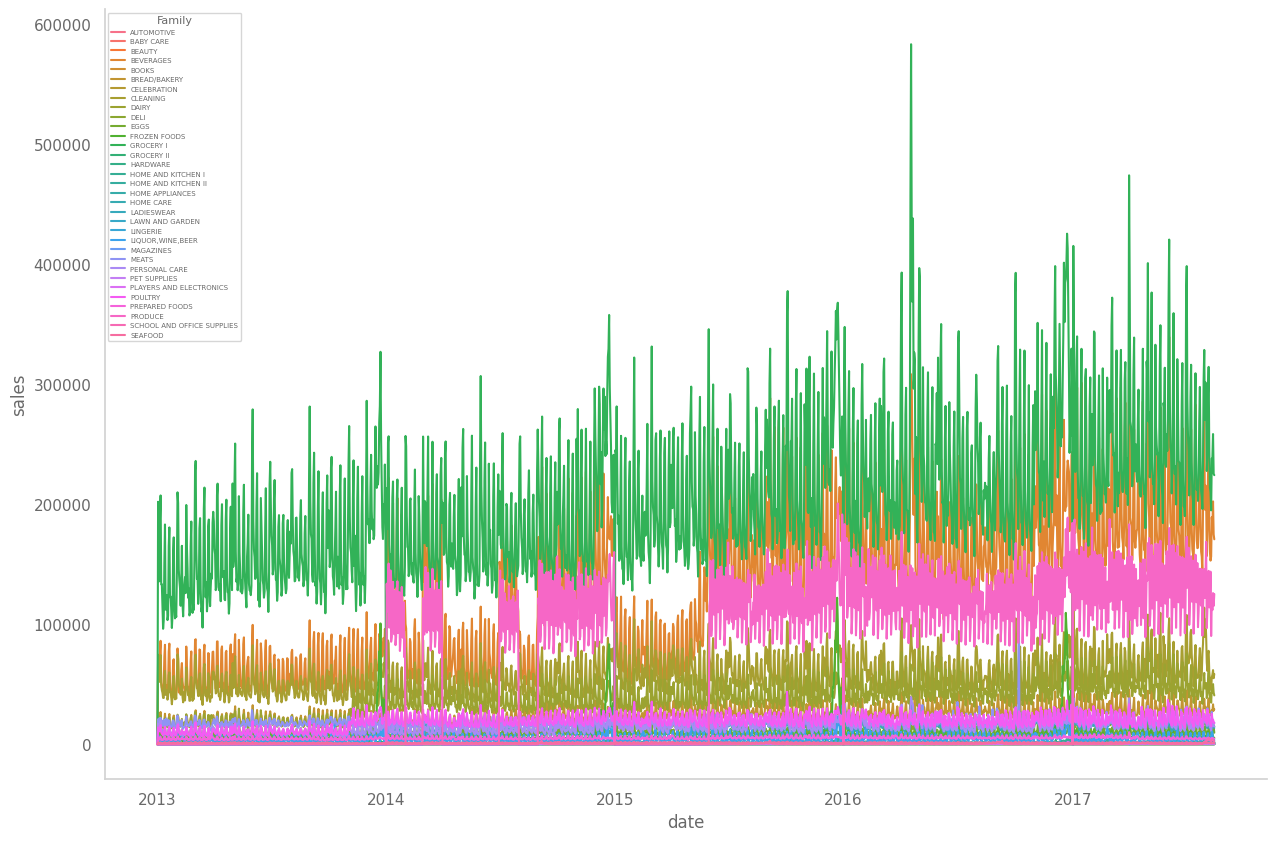

In [11]:
fig, ax = plt.subplots(figsize = ( 15 , 10 ))
g= sns.lineplot(x="date", y="sales", hue="family", markers=True, data=agg_df)
plt.legend(title='Family', loc='upper left',fontsize='5', title_fontsize='8')
plt.show(g)

In [12]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2013-01-01        0.00       0.00    2.00     810.00   0.00        180.59   
2013-01-02      255.00       0.00  207.00   72092.00   0.00      26246.32   
2013-01-03      161.00       0.00  125.00   52105.00   0.00      18456.48   
2013-01-04      169.00       0.00  133.00   54167.00   0.00      16721.97   
2013-01-05      342.00       0.00  191.00   77818.00   0.00      22367.76   
...                ...        ...     ...        ...    ...           ...   
2017-08-11      441.00       7.00  351.00  189111.00   0.00      28204.49   
2017-08-12      403.00       3.00  369.00  182318.00   0.00      27403.55   
2017-08-13      481.00       9.00  433.00  202354.00   1.00      33262.76   
2017-08-14      292.00       9.00  337.00  174832.00   0.00      28002.46   
2017-08-15      337.00       8.00  339.00  170773.00   0.00      29158.20   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2013-01-01         0.00    186.00   143.00    71.09    46.00         29.65   
2013-01-02         0.00  74629.00 23381.00 15754.50 10932.00       7115.39   
2013-01-03         0.00  55893.00 18001.00 11172.45  7358.00       4760.81   
2013-01-04         0.00  52064.00 18148.00 10143.21  6760.00       4525.93   
2013-01-05         0.00  70128.00 23082.00 13734.95  8576.00       5781.61   
...                 ...       ...      ...      ...      ...           ...   
2017-08-11       870.00  55682.00 44909.00 18680.49  9428.00       9473.18   
2017-08-12       849.00  57935.00 42854.00 15689.89  9560.00       9077.45   
2017-08-13       544.00  61757.00 50112.00 17593.27 11478.00       6476.56   
2017-08-14       594.00  55032.00 43050.00 14662.74 14600.00       5422.67   
2017-08-15       597.00  58474.00 40707.00 14935.45  9624.00       5309.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2013-01-01     700.00       15.00      0.00                0.00   
2013-01-02  202020.00     1476.00     46.00                0.00   
2013-01-03  144878.00     1048.00     37.00                0.00   
2013-01-04  135754.00     1031.00     57.00                0.00   
2013-01-05  188356.00     1273.00     87.00                0.00   
...               ...         ...       ...                 ...   
2017-08-11  238221.92     1653.00     83.00             2189.00   
2017-08-12  238627.63     1555.00     89.00             2046.00   
2017-08-13  258442.45     1504.00    108.00             1874.00   
2017-08-14  225355.69     1371.00     66.00             1682.00   
2017-08-15  224208.12     1300.00     57.00             1669.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2013-01-01                 0.00             0.00       0.00        0.00   
2013-01-02                 0.00            21.00       0.00        0.00   
2013-01-03                 0.00            15.00       0.00        0.00   
2013-01-04                 0.00            13.00       0.00        0.00   
2013-01-05                 0.00            11.00       0.00        0.00   
...                         ...              ...        ...         ...   
2017-08-11              1504.00            10.00   13747.00      460.00   
2017-08-12              1504.00             8.00   14692.00      599.00   
2017-08-13              1625.00             2.00   16564.00      722.00   
2017-08-14              1668.00             4.00   13818.00      487.00   
2017-08-15              1448.00             3.00   13644.00      503.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                    

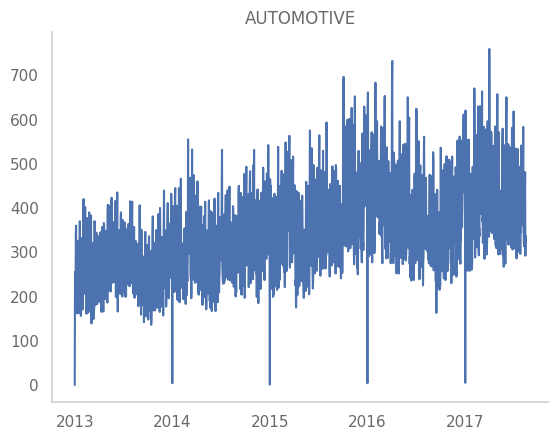

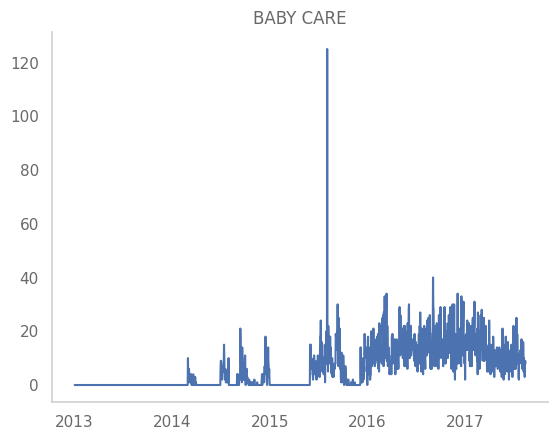

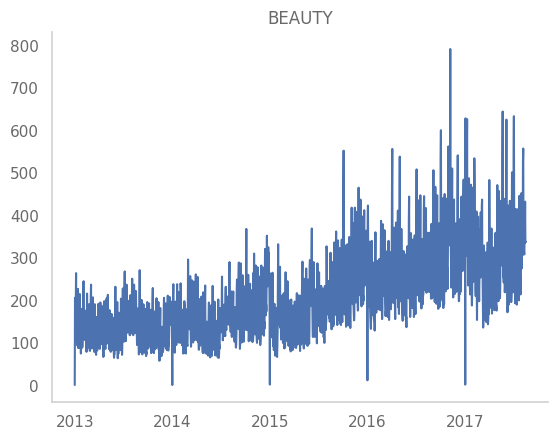

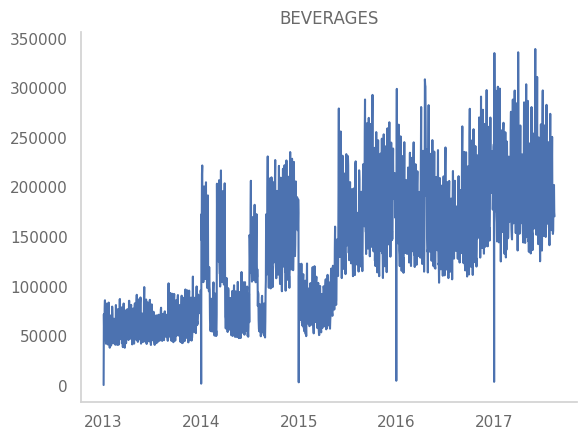

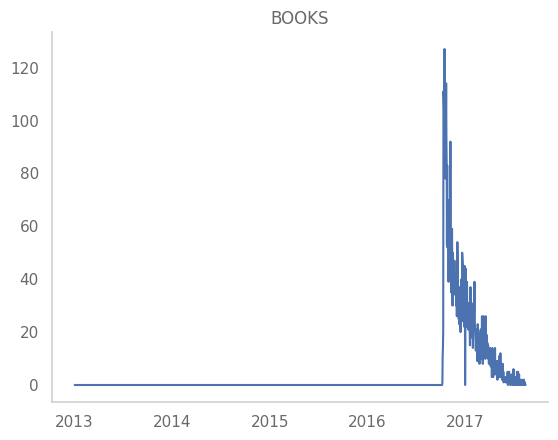

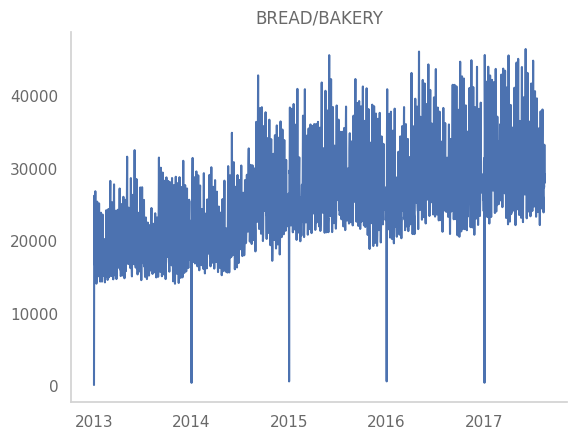

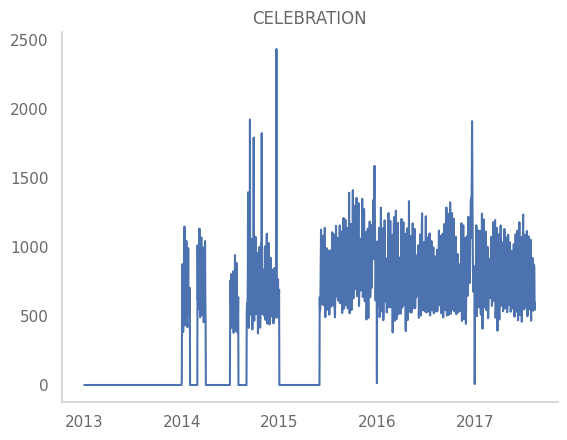

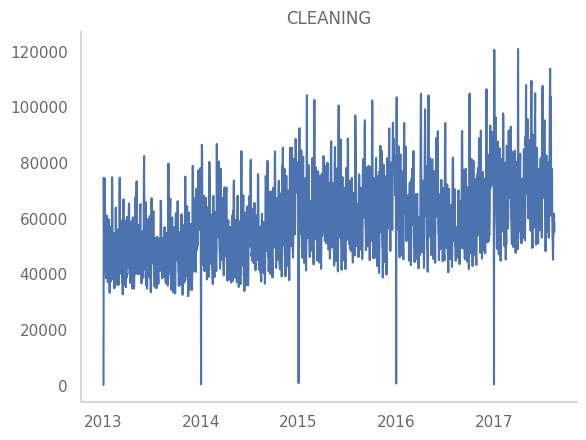

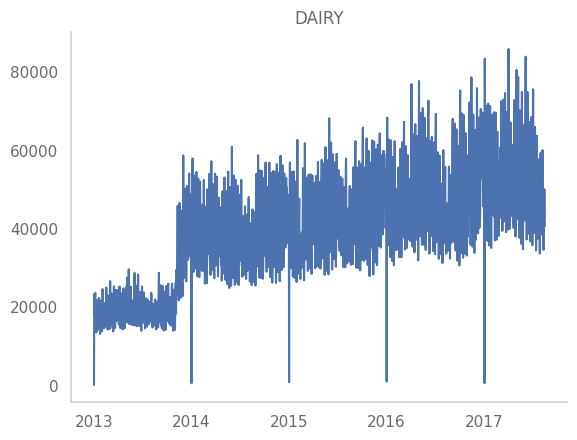

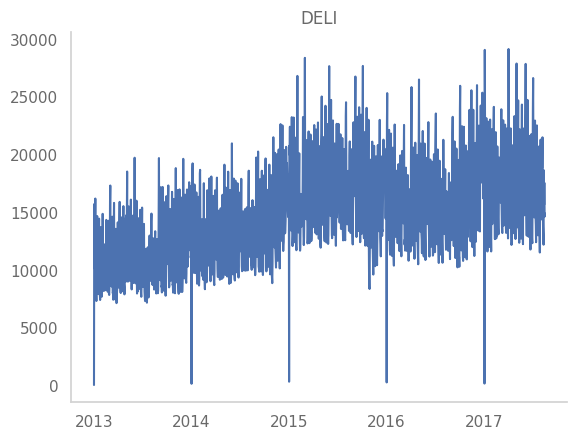

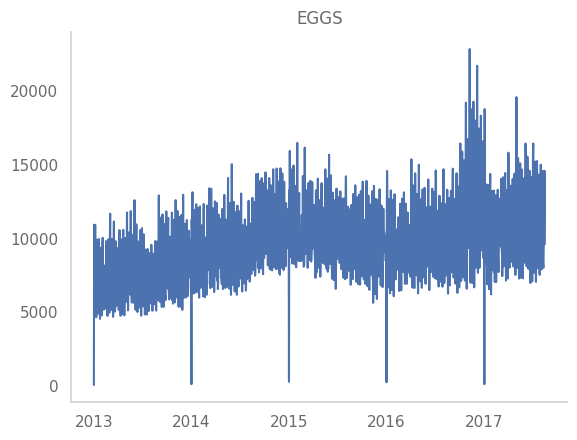

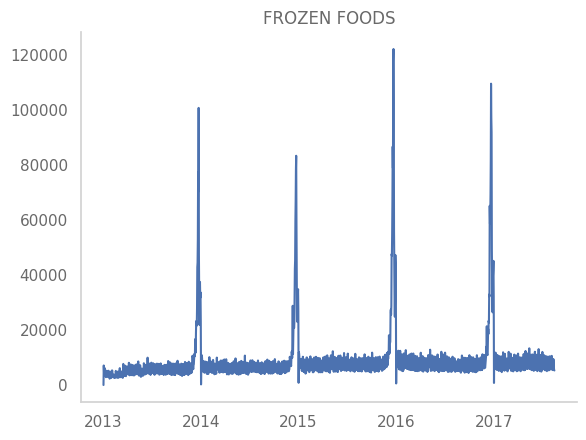

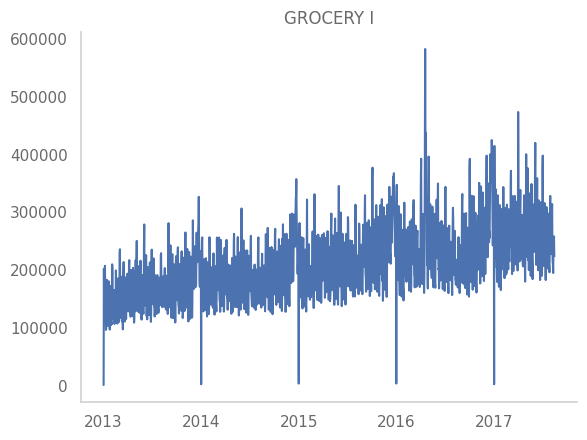

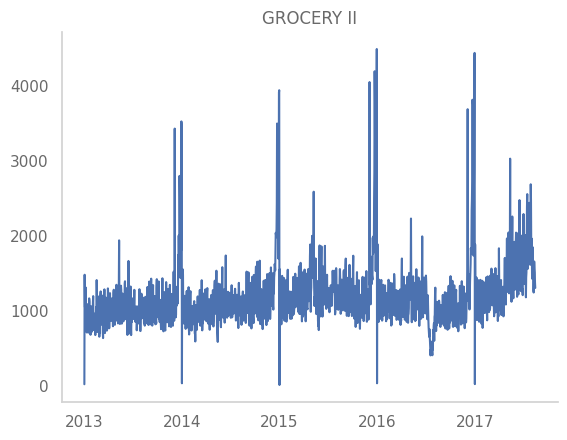

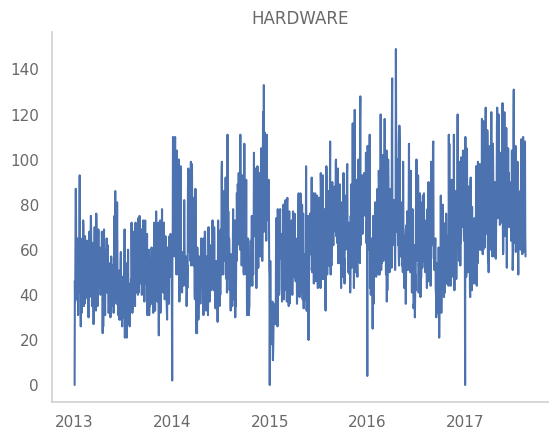

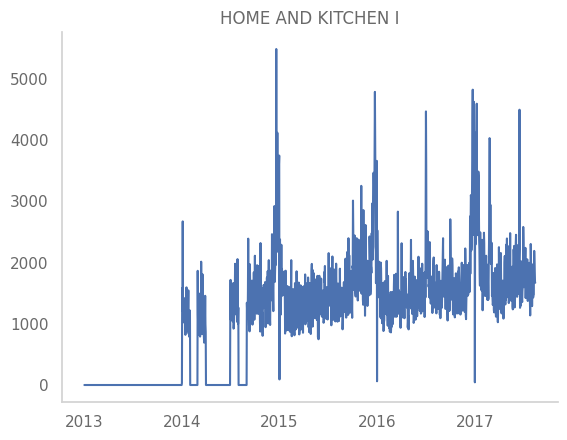

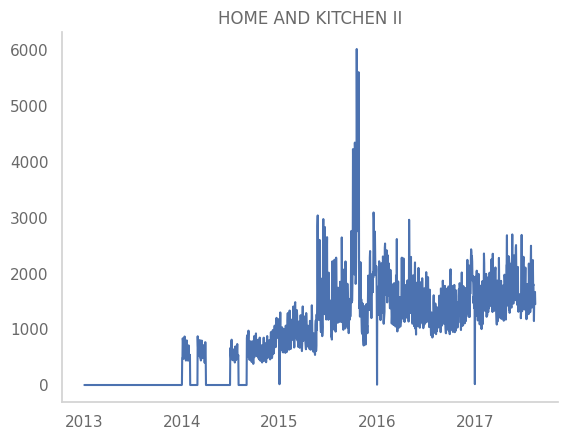

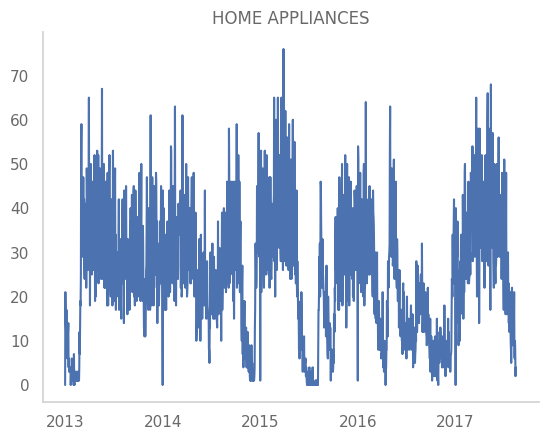

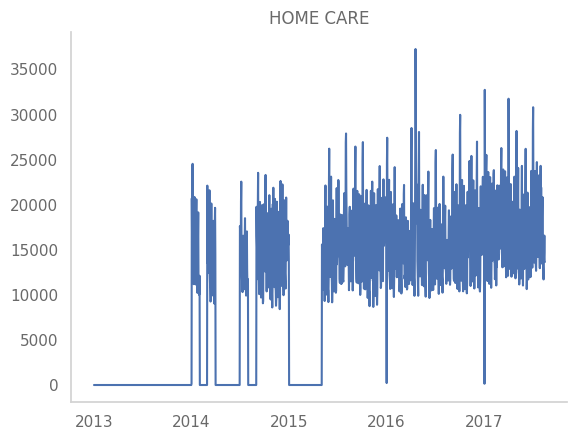

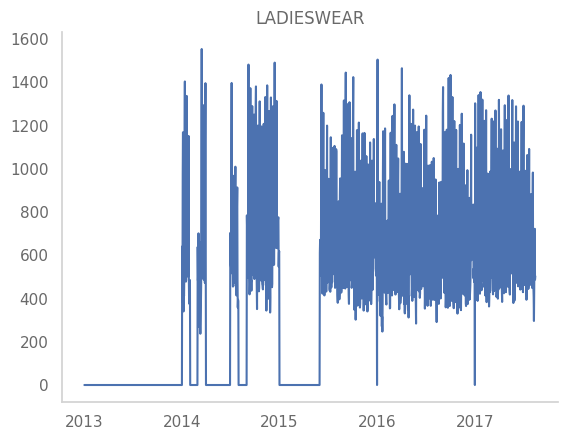

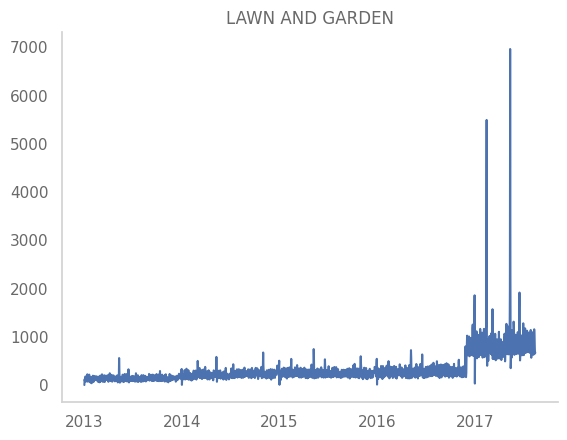

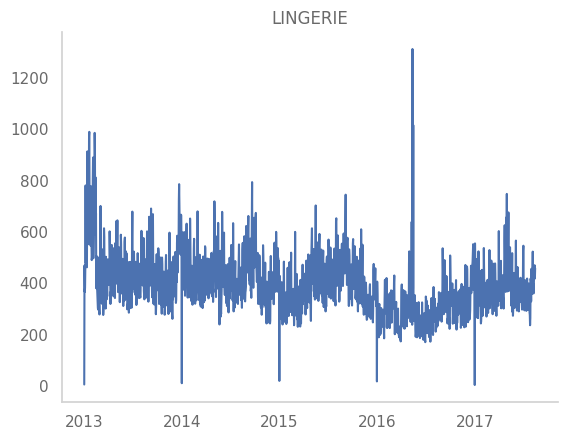

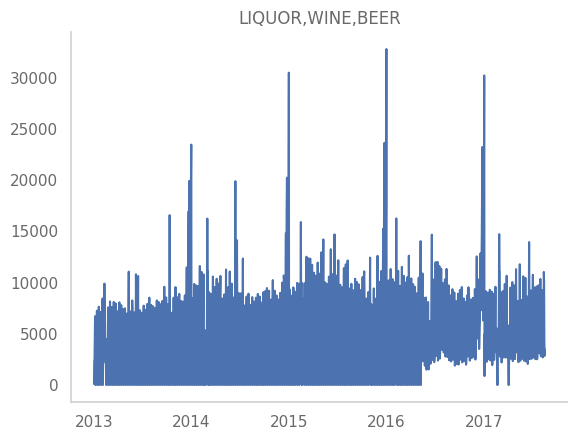

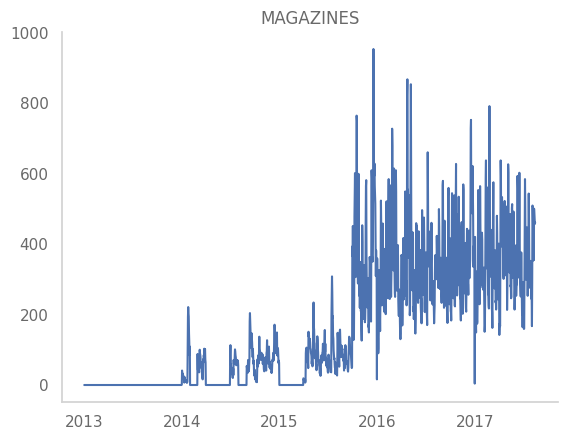

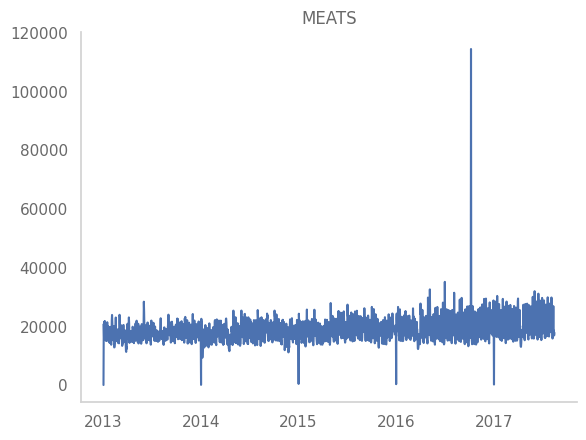

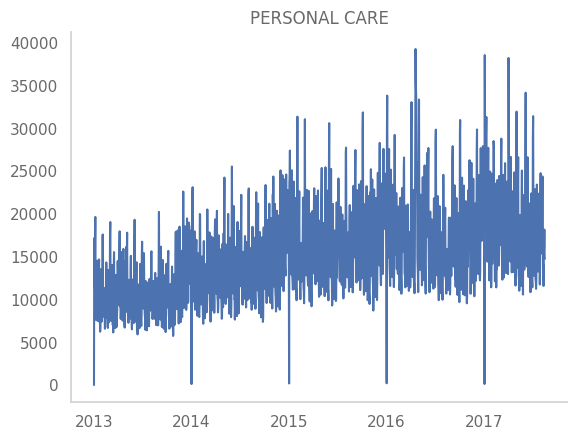

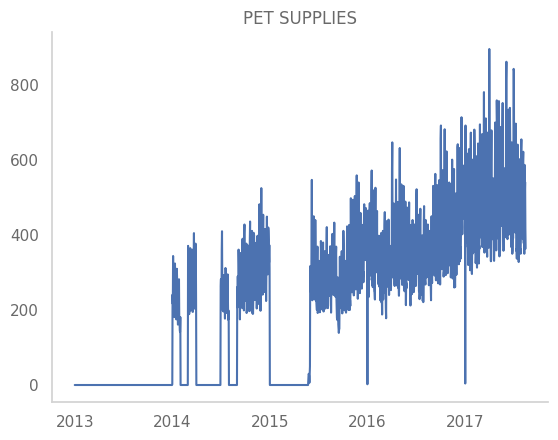

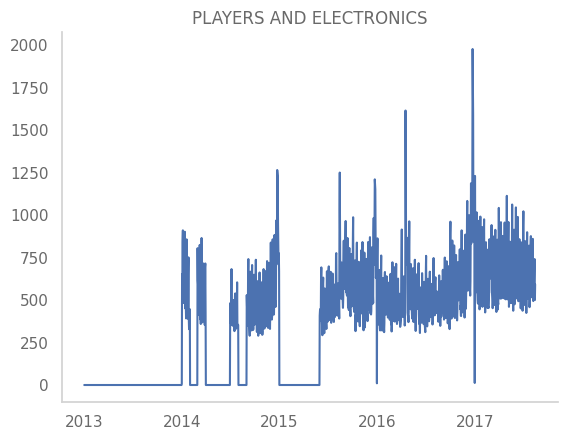

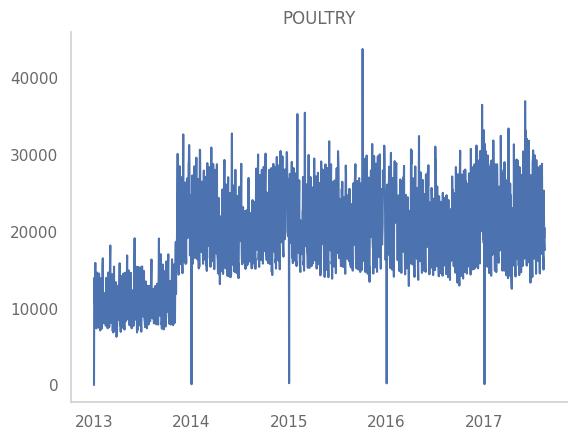

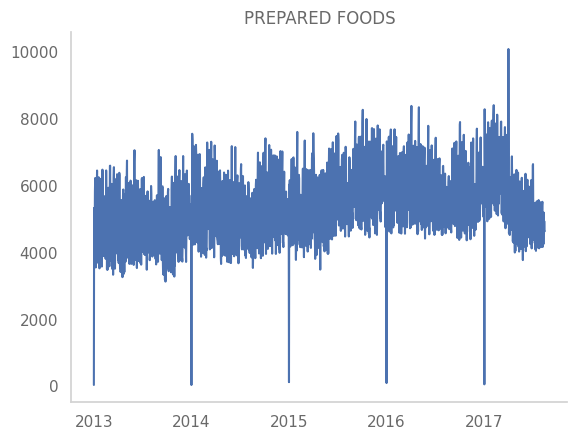

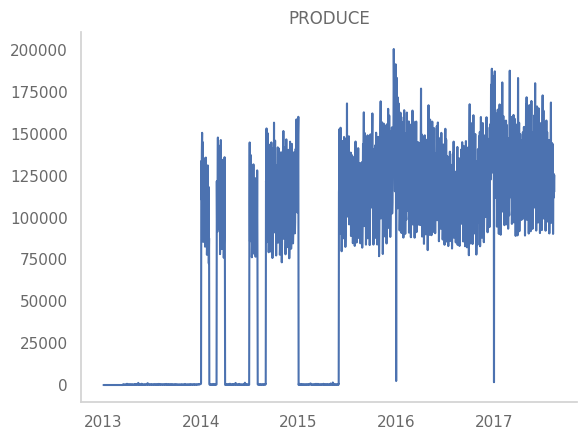

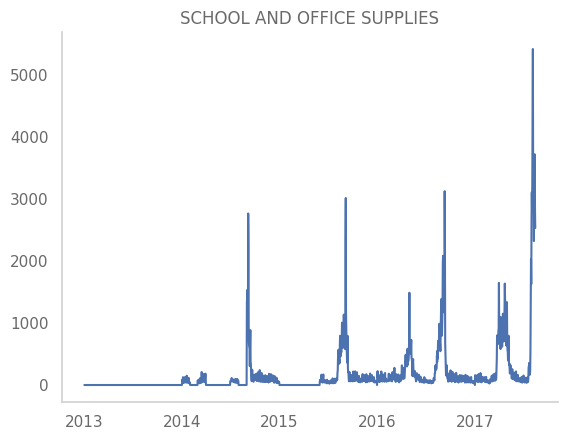

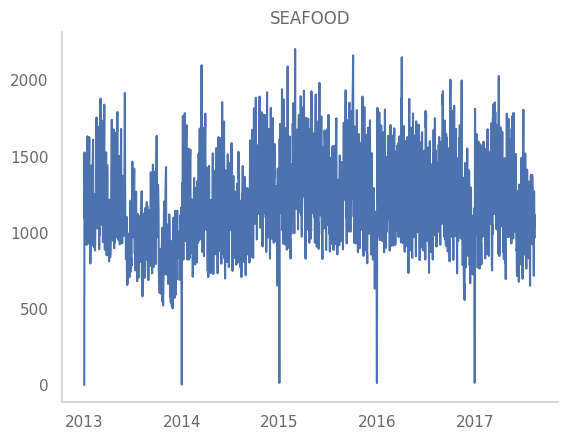

In [13]:
'''
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()
    
'''
# both giving same results but different way
for column in agg_df["family"].unique():
    plt.plot(agg_df[agg_df.family==column].date,agg_df[agg_df.family==column].sales)
    plt.title(column)
    plt.show()

#### We're gonna use data after 2015-08-15. Because of most of the family shows regular expresssion after 2015-08-15.

In [14]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [15]:
total_sales_df

family      AUTOMOTIVE  BABY CARE  BEAUTY  BEVERAGES  BOOKS  BREAD/BAKERY  \
date                                                                        
2015-08-15      454.00      18.00  251.00  217135.00   0.00      32509.91   
2015-08-16      413.00      11.00  313.00  208213.00   0.00      34851.88   
2015-08-17      289.00      14.00  175.00  149741.00   0.00      26361.77   
2015-08-18      295.00      10.00  166.00  132609.00   0.00      23915.95   
2015-08-19      314.00       5.00  176.00  131368.00   0.00      23995.15   
...                ...        ...     ...        ...    ...           ...   
2017-08-11      441.00       7.00  351.00  189111.00   0.00      28204.49   
2017-08-12      403.00       3.00  369.00  182318.00   0.00      27403.55   
2017-08-13      481.00       9.00  433.00  202354.00   1.00      33262.76   
2017-08-14      292.00       9.00  337.00  174832.00   0.00      28002.46   
2017-08-15      337.00       8.00  339.00  170773.00   0.00      29158.20   

family      CELEBRATION  CLEANING    DAIRY     DELI     EGGS  FROZEN FOODS  \
date                                                                         
2015-08-15      1157.00  75837.00 48578.00 19946.92 11232.00      10075.02   
2015-08-16       724.00  75824.00 50930.00 21178.46 11977.00       7526.03   
2015-08-17       593.00  59718.00 38358.00 15755.02 10713.00       5145.30   
2015-08-18       709.00  52749.00 33273.00 14119.25  8123.00       5050.99   
2015-08-19       599.00  51157.00 35760.00 13250.04  8001.00       5372.18   
...                 ...       ...      ...      ...      ...           ...   
2017-08-11       870.00  55682.00 44909.00 18680.49  9428.00       9473.18   
2017-08-12       849.00  57935.00 42854.00 15689.89  9560.00       9077.45   
2017-08-13       544.00  61757.00 50112.00 17593.27 11478.00       6476.56   
2017-08-14       594.00  55032.00 43050.00 14662.74 14600.00       5422.67   
2017-08-15       597.00  58474.00 40707.00 14935.45  9624.00       5309.61   

family      GROCERY I  GROCERY II  HARDWARE  HOME AND KITCHEN I  \
date                                                              
2015-08-15  280491.48     1552.00    108.00             1899.00   
2015-08-16  266657.28     1441.00     62.00             1418.00   
2015-08-17  205150.61     1161.00     49.00             1143.00   
2015-08-18  181016.01      955.00     69.00             1181.00   
2015-08-19  178550.63     1011.00     55.00             1132.00   
...               ...         ...       ...                 ...   
2017-08-11  238221.92     1653.00     83.00             2189.00   
2017-08-12  238627.63     1555.00     89.00             2046.00   
2017-08-13  258442.45     1504.00    108.00             1874.00   
2017-08-14  225355.69     1371.00     66.00             1682.00   
2017-08-15  224208.12     1300.00     57.00             1669.00   

family      HOME AND KITCHEN II  HOME APPLIANCES  HOME CARE  LADIESWEAR  \
date                                                                      
2015-08-15              1526.00            46.00   18924.00      879.00   
2015-08-16              1850.00            45.00   19757.00      955.00   
2015-08-17              1343.00            36.00   14120.00      564.00   
2015-08-18              1320.00            31.00   12202.00      485.00   
2015-08-19              1249.00            27.00   12042.00      492.00   
...                         ...              ...        ...         ...   
2017-08-11              1504.00            10.00   13747.00      460.00   
2017-08-12              1504.00             8.00   14692.00      599.00   
2017-08-13              1625.00             2.00   16564.00      722.00   
2017-08-14              1668.00             4.00   13818.00      487.00   
2017-08-15              1448.00             3.00   13644.00      503.00   

family      LAWN AND GARDEN  LINGERIE  LIQUOR,WINE,BEER  MAGAZINES    MEATS  \
date                                                    

### Checking for missing values  <a class="anchor"  id="chapter3.3"></a>

In [16]:
missing_data(total_sales_df)

Total  Percent    Types
family                                             
AUTOMOTIVE                      0     0.00  float64
BABY CARE                       0     0.00  float64
BEAUTY                          0     0.00  float64
BEVERAGES                       0     0.00  float64
BOOKS                           0     0.00  float64
BREAD/BAKERY                    0     0.00  float64
CELEBRATION                     0     0.00  float64
CLEANING                        0     0.00  float64
DAIRY                           0     0.00  float64
DELI                            0     0.00  float64
EGGS                            0     0.00  float64
FROZEN FOODS                    0     0.00  float64
GROCERY I                       0     0.00  float64
GROCERY II                      0     0.00  float64
HARDWARE                        0     0.00  float64
HOME AND KITCHEN I              0     0.00  float64
HOME AND KITCHEN II             0     0.00  float64
HOME APPLIANCES                 0     0.00  float64
HOME CARE                       0     0.00  float64
LADIESWEAR                      0     0.00  float64
LAWN AND GARDEN                 0     0.00  float64
LINGERIE                        0     0.00  float64
LIQUOR,WINE,BEER                0     0.00  float64
MAGAZINES                       0     0.00  float64
MEATS                           0     0.00  float64
PERSONAL CARE                   0     0.00  float64
PET SUPPLIES                    0     0.00  float64
PLAYERS AND ELECTRONICS         0     0.00  float64
POULTRY                         0     0.00  float64
PREPARED FOODS                  0     0.00  float64
PRODUCE                         0     0.00  float64
SCHOOL AND OFFICE SUPPLIES      0     0.00  float64
SEAFOOD                         0     0.00  float64

### Remove low-volume(Average under 1000) columns <a class="anchor"  id="chapter3.1"></a>

In [17]:
#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

### Removing Outlies  <a class="anchor"  id="chapter3.2"></a>
-By z-score method 

In [18]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = [] # before using list. I thought why I'm not using main dataframe. which is I could concat each cleaned dataframe. 
# But than ı realized that every cleaned dataset will have different date's. And they can't concat/merge with any index value.


for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 3)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 5 rows for following category: BEVERAGES
Dropping 3 rows for following category: BREAD/BAKERY
Dropping 5 rows for following category: CLEANING
Dropping 6 rows for following category: DAIRY
Dropping 7 rows for following category: DELI
Dropping 11 rows for following category: EGGS
Dropping 17 rows for following category: FROZEN FOODS
Dropping 8 rows for following category: GROCERY I
Dropping 13 rows for following category: GROCERY II
Dropping 16 rows for following category: HOME AND KITCHEN I
Dropping 10 rows for following category: HOME AND KITCHEN II
Dropping 8 rows for following category: HOME CARE
Dropping 8 rows for following category: LIQUOR,WINE,BEER
Dropping 3 rows for following category: MEATS
Dropping 10 rows for following category: PERSONAL CARE
Dropping 5 rows for following category: POULTRY
Dropping 3 rows for following category: PREPARED FOODS
Dropping 3 rows for following category: PRODUCE
Dropping 3 rows for following category: SEAFOOD


#### Visualisation for seeing the changes and how they affected our data, removing outliers in general <a class="anchor"  id="chapter3.2.1"></a>

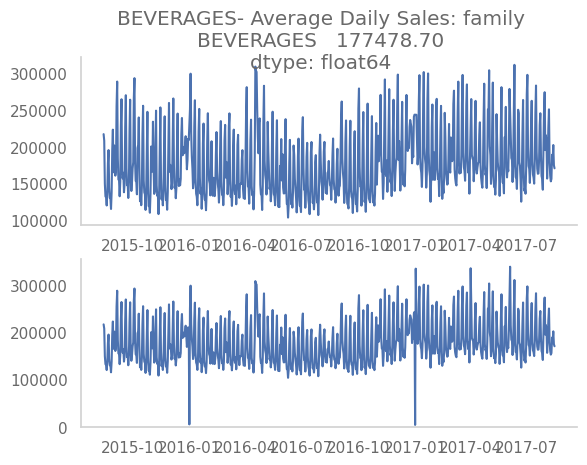

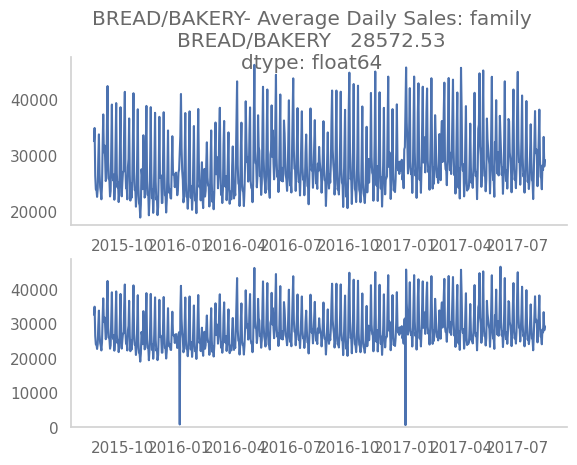

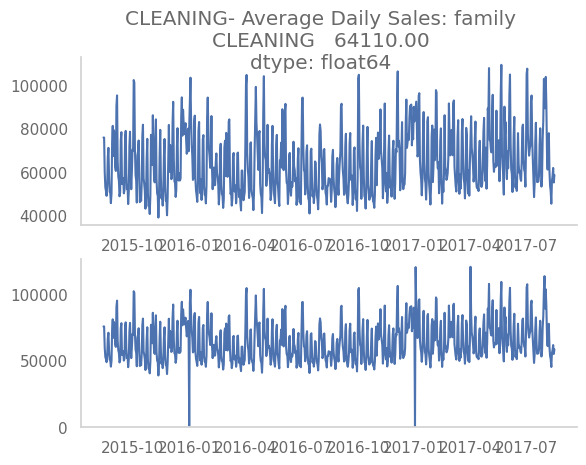

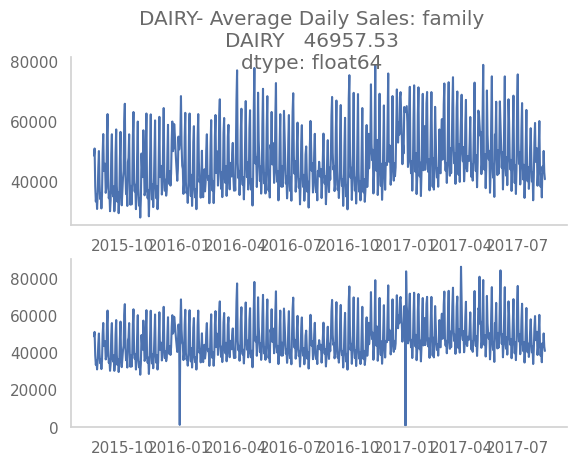

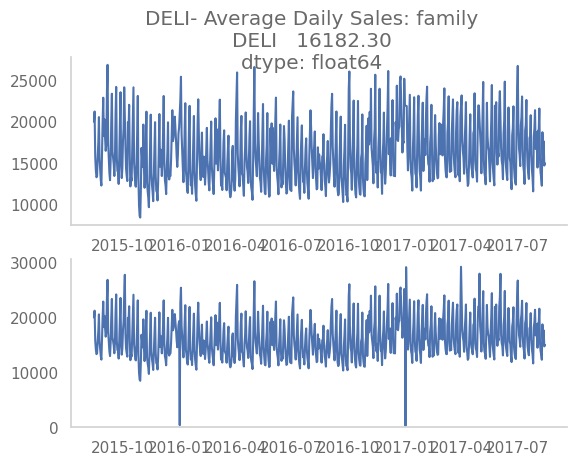

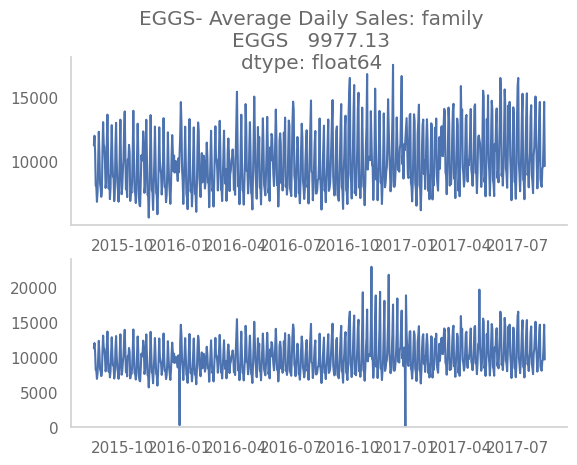

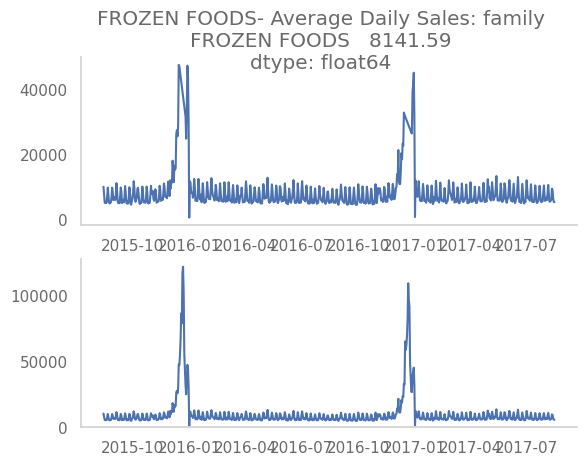

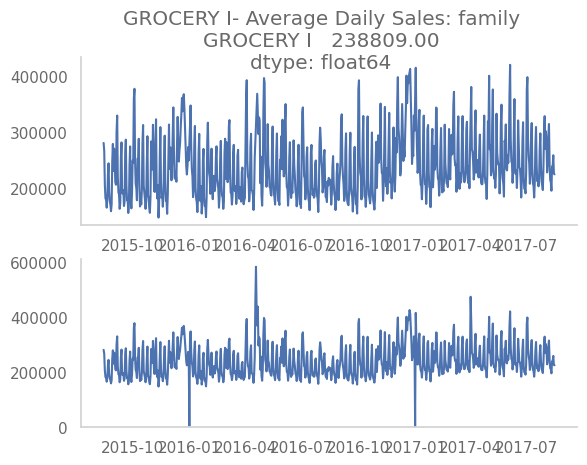

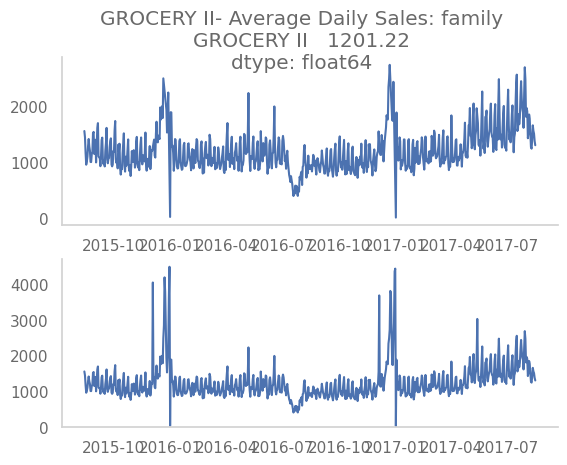

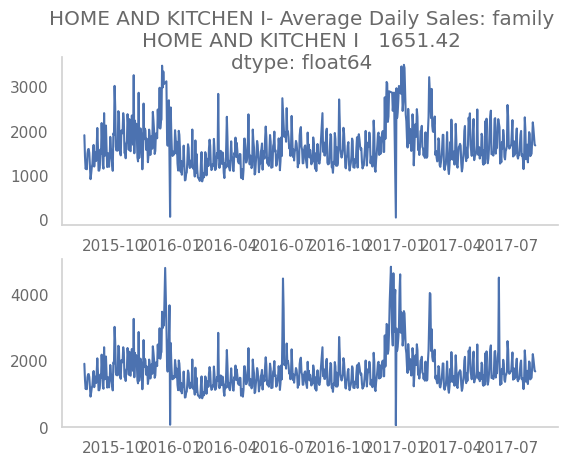

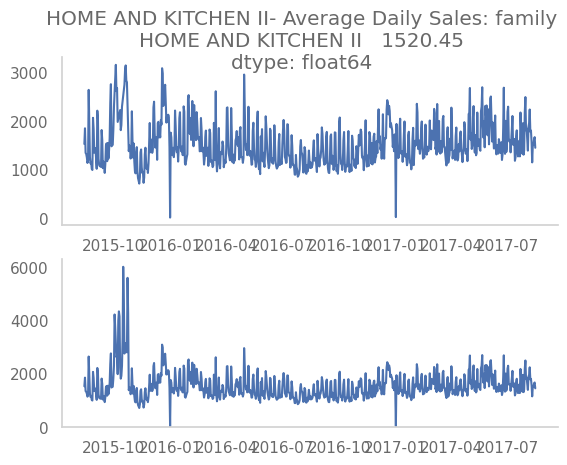

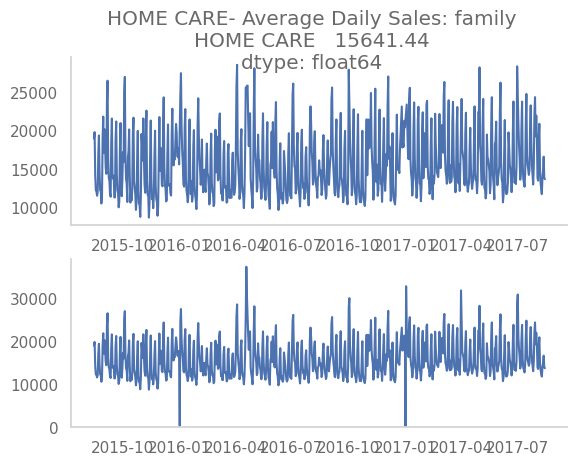

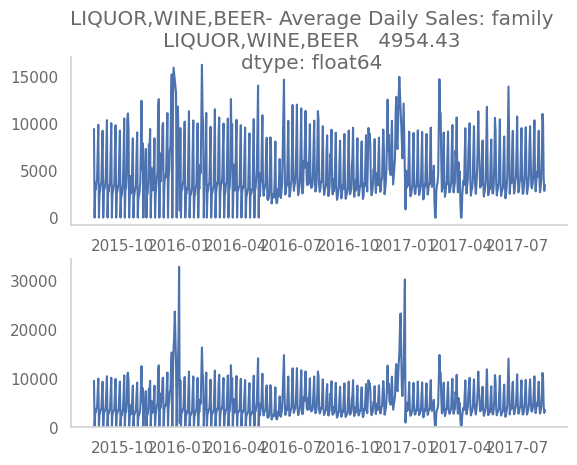

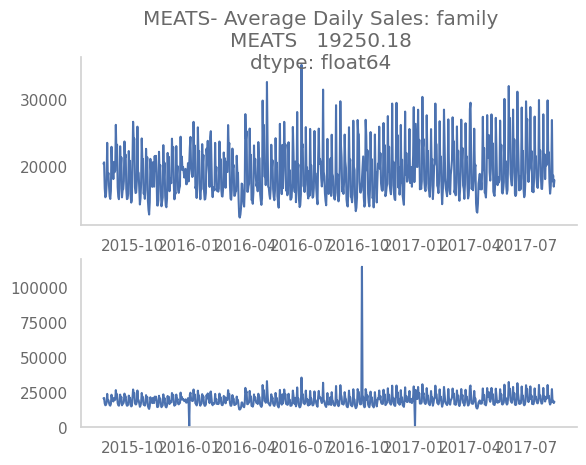

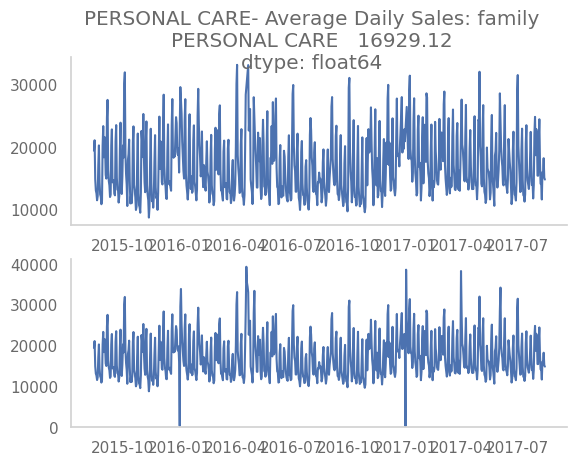

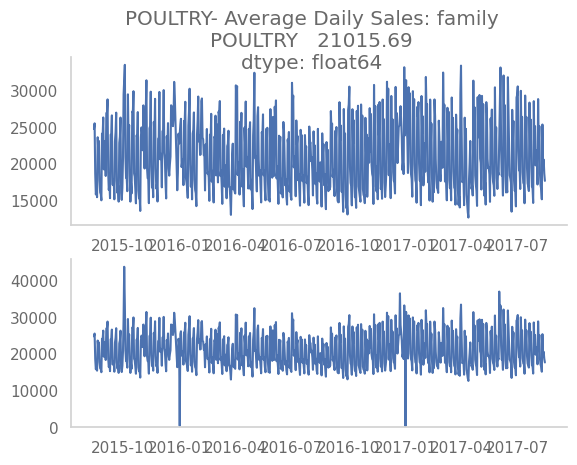

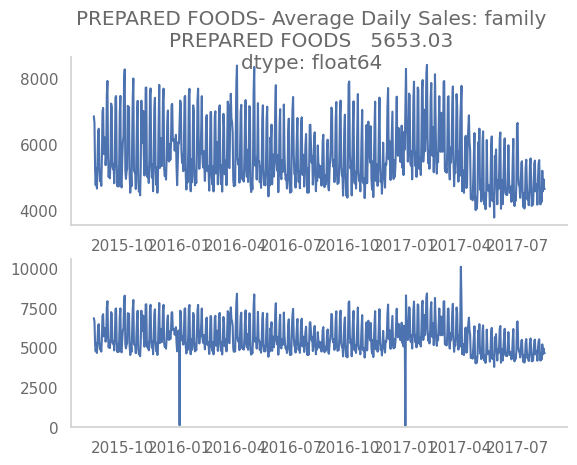

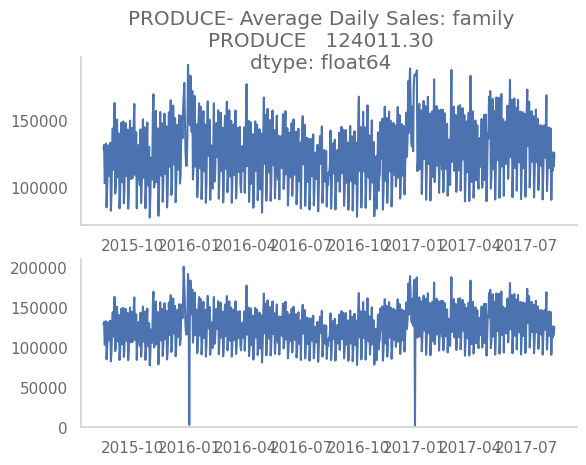

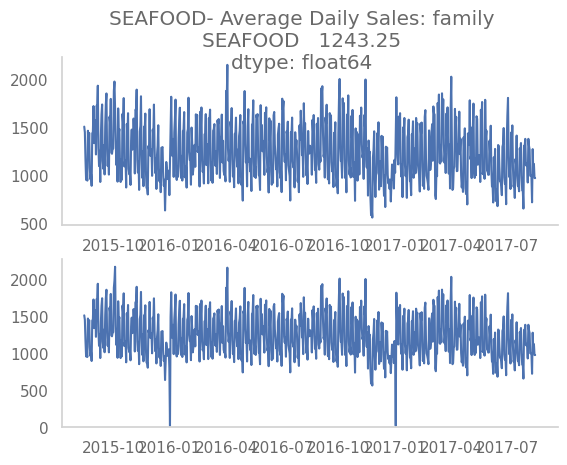

In [19]:
for i in range(len(prediction_df_list)):
    
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    ax1.plot(prediction_df_list[i])
    ax2.plot(total_sales_df.iloc[:,i])
    plt.ylim(ymin=0)

    plt.show()

### Separating data in different datasets by volume of sales <a class="anchor"  id="chaptera"></a>

The higher volume data the better for forecasting since you can forecast past the noise and end up with lower error bars. This will also let us visualize the forecasts on similar scales so that we can figure out if timeseries modeling will work for the categories since timeseries highly depends on seasonal data of a certain variation (addtitive, multiplicative)

In [20]:
# agg_df[agg_df["date"]>='2015-08-15'].groupby("family")["sales"].mean().sort_values()
# same result with different method.

avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
avg_daily_sales

family
SEAFOOD                 1241.14
GROCERY II              1246.87
HOME AND KITCHEN II     1560.60
HOME AND KITCHEN I      1707.09
LIQUOR,WINE,BEER        5157.08
PREPARED FOODS          5643.84
FROZEN FOODS            9828.31
EGGS                   10069.28
HOME CARE              15734.36
DELI                   16222.12
PERSONAL CARE          17091.29
MEATS                  19328.74
POULTRY                21032.82
BREAD/BAKERY           28520.34
DAIRY                  47031.14
CLEANING               64159.21
PRODUCE               123782.00
BEVERAGES             177660.02
GROCERY I             240048.18
dtype: float64

In [21]:
low, mid = np.percentile(avg_daily_sales,[33,66])

In [22]:
low_vol_columns = list(avg_daily_sales[avg_daily_sales<=low].index)
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

#### Plotting low-sales volume columns <a class="anchor"  id="chaptera.1"></a>

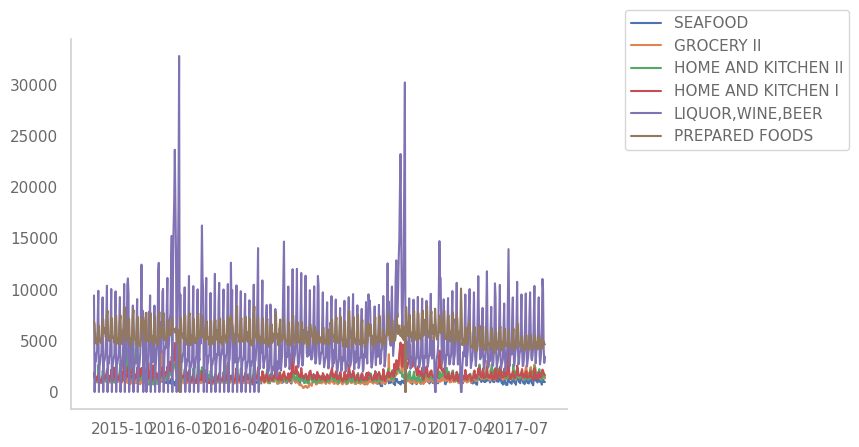

In [23]:
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best' , bbox_to_anchor=(1.1, 1.1))
plt.show()

#### Plotting mid-sales volume columns <a class="anchor"  id="chaptera.2"></a>

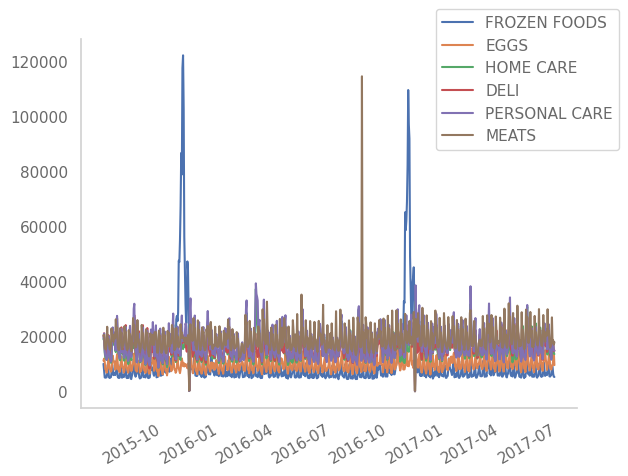

In [24]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

#### Plotting high-volume sales columns <a class="anchor"  id="chaptera.3"></a>

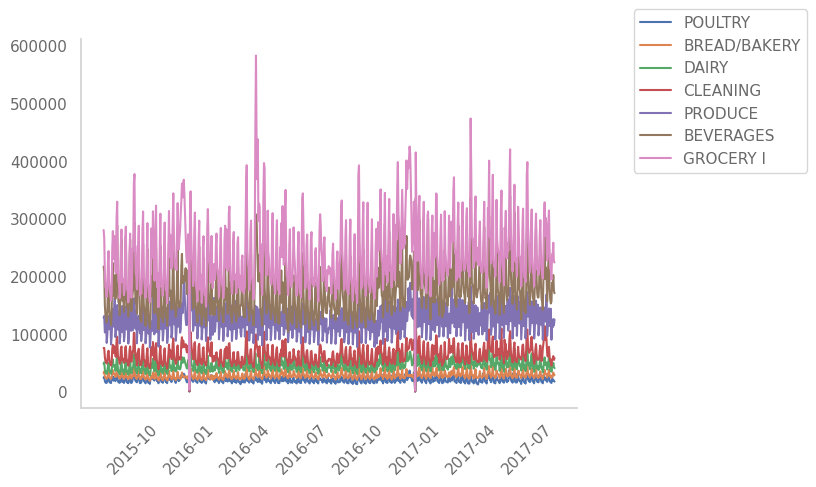

In [25]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=45)
plt.show()

In [26]:
#setting variable
feature = 'PRODUCE'

In [27]:
for i in range(len(prediction_df_list)):
    if prediction_df_list[i].columns=="PRODUCE":
        print(i)
        df= prediction_df_list[i]   

17


In [28]:
df["date"]=df.index
df = df.reset_index(drop=True)
df

family   PRODUCE       date
0      128147.18 2015-08-15
1      131493.93 2015-08-16
2      102769.60 2015-08-17
3      106468.23 2015-08-18
4      132449.58 2015-08-19
..           ...        ...
722    118738.14 2017-08-11
723    111788.35 2017-08-12
724    125923.80 2017-08-13
725    115257.60 2017-08-14
726    125108.97 2017-08-15

[727 rows x 2 columns]

In [29]:
### Creating Holiday dataframe

In [30]:
'''
# FOR TURKEY(YOU CAN İGNORE IT'S JUST FOR CURIOSITY)

holiday = pd.DataFrame([])
for date_, name in sorted(holidays.TR(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': name, 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday
'''

"\n# FOR TURKEY(YOU CAN İGNORE IT'S JUST FOR CURIOSITY)\n\nholiday = pd.DataFrame([])\nfor date_, name in sorted(holidays.TR(years=[2015,2016,2017,2018]).items()):\n    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': name, 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) \n\nholiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')\nholiday\n"

In [31]:
#adding holidays data for Ecuador

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2015-01-01  EC-Holidays            -2             1
1 2015-02-16  EC-Holidays            -2             1
2 2015-02-17  EC-Holidays            -2             1
3 2015-04-03  EC-Holidays            -2             1
4 2015-05-01  EC-Holidays            -2             1

Soo let me summarize above section. What we've done in there.

* -First we created dataframe object as a "holiday".
* -Then second code block is for showing us the how we getting holidays from framework.(so it's mean not necessary)
* -The last code block(which is starts from "for" loop. We got holiday dates and holiday names from framework.Than we iterated in each item. Than we concated every item with new dataframe format which is holiday name is "EC-Holidays" added two more columns for future usage.
* -Than we ended up with transforming datetime format

In [32]:
#Variables

prediction_days = 30
forecast_start_dt = date(2017,7,1) #dataset ends of (2017,8,15)
forecast_start_date = (forecast_start_dt).strftime("%Y-%m-%d") #strftime: string format time. Tranforming string format to given date format
print(forecast_start_date)

2017-07-01


In [33]:
df

family   PRODUCE       date
0      128147.18 2015-08-15
1      131493.93 2015-08-16
2      102769.60 2015-08-17
3      106468.23 2015-08-18
4      132449.58 2015-08-19
..           ...        ...
722    118738.14 2017-08-11
723    111788.35 2017-08-12
724    125923.80 2017-08-13
725    115257.60 2017-08-14
726    125108.97 2017-08-15

[727 rows x 2 columns]

### Modelling <a class="anchor"  id="chapter4"></a>

In [34]:
#PROPHET MODEL

df_copy = df.copy()
df_copy = df_copy.rename(columns={'date': 'ds', feature: 'y'}) # we used feature instead of "PRODUCE". And transformed "ds" because of model 
df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)
# df_copy for checking dataset


df_copy['ds'] = pd.to_datetime(df_copy['ds']) # datetime transforming

train_set = df_copy[(df_copy['ds'] < forecast_start_date) ] # we'll train our model before "forecast_start_date" date

m = Prophet()

m.fit(train_set)

future = m.make_future_dataframe(periods=prediction_days) # it create a dataframe which is including dates for prediction
# By default it will also include the dates from the history, so we will see the model fit as well.
fcst_prophet_train = m.predict(future)

#adding filter to only add the forecasted last 30 days data into predicted_df
filter = fcst_prophet_train['ds']>=forecast_start_date 
predicted_df = fcst_prophet_train[filter][['ds','yhat']] # filter for last 30 days , if we doenst add filter it give us over 700 forecasted data

12:37:49 - cmdstanpy - INFO - Chain [1] start processing
12:37:49 - cmdstanpy - INFO - Chain [1] done processing


In [35]:
# there are a lot of feature in forcast_prophet_train but we only use yhat feature which is mean prediction
# you can see all features when you execute below code.
# fcst_prophet_train 

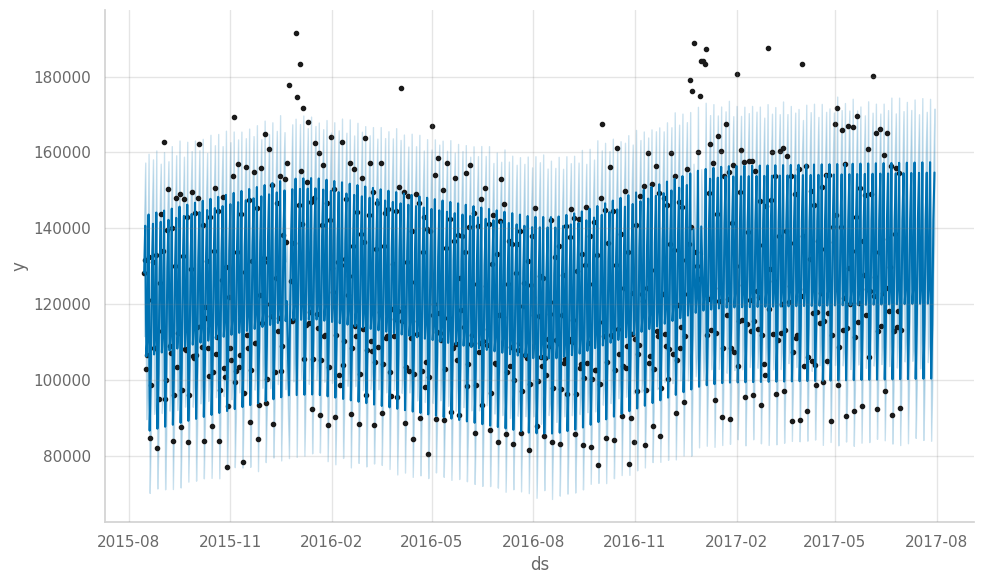

In [36]:
fig1 = m.plot(fcst_prophet_train)

### Plotting Model  <a class="anchor"  id="chapter4.1"></a>

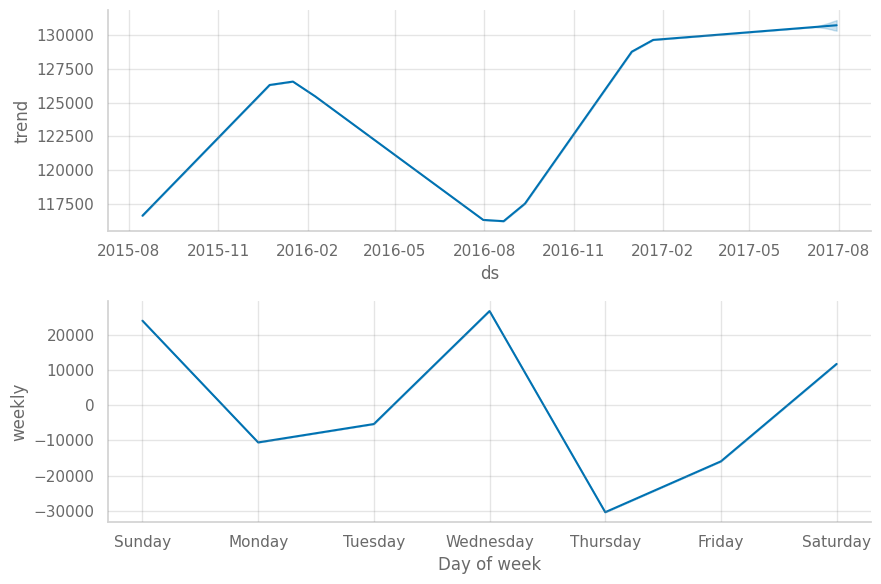

In [37]:
fig2 = m.plot_components(fcst_prophet_train)

In [38]:
predicted_df.head(10)

ds      yhat
681 2017-07-01 142276.62
682 2017-07-02 154554.99
683 2017-07-03 119989.85
684 2017-07-04 125219.57
685 2017-07-05 157315.78
686 2017-07-06 100186.38
687 2017-07-07 114637.47
688 2017-07-08 142316.83
689 2017-07-09 154595.20
690 2017-07-10 120030.05

In [39]:
df

family   PRODUCE       date
0      128147.18 2015-08-15
1      131493.93 2015-08-16
2      102769.60 2015-08-17
3      106468.23 2015-08-18
4      132449.58 2015-08-19
..           ...        ...
722    118738.14 2017-08-11
723    111788.35 2017-08-12
724    125923.80 2017-08-13
725    115257.60 2017-08-14
726    125108.97 2017-08-15

[727 rows x 2 columns]

In [42]:
df_copy

ds      ytrue
0   128147.18 2015-08-15
1   131493.93 2015-08-16
2   102769.60 2015-08-17
3   106468.23 2015-08-18
4   132449.58 2015-08-19
..        ...        ...
722 118738.14 2017-08-11
723 111788.35 2017-08-12
724 125923.80 2017-08-13
725 115257.60 2017-08-14
726 125108.97 2017-08-15

[727 rows x 2 columns]

In [40]:
 predicted_df

ds      yhat
681 2017-07-01 142276.62
682 2017-07-02 154554.99
683 2017-07-03 119989.85
684 2017-07-04 125219.57
685 2017-07-05 157315.78
686 2017-07-06 100186.38
687 2017-07-07 114637.47
688 2017-07-08 142316.83
689 2017-07-09 154595.20
690 2017-07-10 120030.05
691 2017-07-11 125259.77
692 2017-07-12 157355.98
693 2017-07-13 100226.59
694 2017-07-14 114677.68
695 2017-07-15 142357.03
696 2017-07-16 154635.41
697 2017-07-17 120070.26
698 2017-07-18 125299.98
699 2017-07-19 157396.19
700 2017-07-20 100266.80
701 2017-07-21 114717.88
702 2017-07-22 142397.24
703 2017-07-23 154675.61
704 2017-07-24 120110.47
705 2017-07-25 125340.19
706 2017-07-26 157436.40
707 2017-07-27 100307.00
708 2017-07-28 114758.09
709 2017-07-29 142437.45
710 2017-07-30 154715.82

In [43]:
df_copy = df.copy()
df_copy.columns = ['ytrue', 'ds'] # normally column names was date and PRODUCE.
predicted_df = predicted_df.merge(df_copy) # Normally df_copy has 730 rows data. But merg function just merging matching data by ds

In [44]:
predicted_df

ds      yhat     ytrue
0  2017-07-01 142276.62 155487.63
1  2017-07-02 154554.99 172890.14
2  2017-07-03 119989.85 130389.20
3  2017-07-04 125219.57 131534.55
4  2017-07-05 157315.78 163804.33
5  2017-07-06 100186.38  99395.60
6  2017-07-07 114637.47 114346.57
7  2017-07-08 142316.83 139294.77
8  2017-07-09 154595.20 156633.92
9  2017-07-10 120030.05 118856.99
10 2017-07-11 125259.77 122176.36
11 2017-07-12 157355.98 152978.41
12 2017-07-13 100226.59  92111.27
13 2017-07-14 114677.68 110263.08
14 2017-07-15 142357.03 133166.71
15 2017-07-16 154635.41 157883.06
16 2017-07-17 120070.26 119026.44
17 2017-07-18 125299.98 118281.40
18 2017-07-19 157396.19 150952.70
19 2017-07-20 100266.80  97593.17
20 2017-07-21 114717.88 110555.13
21 2017-07-22 142397.24 130700.68
22 2017-07-23 154675.61 146226.46
23 2017-07-24 120110.47 117117.10
24 2017-07-25 125340.19 115457.66
25 2017-07-26 157436.40 145917.92
26 2017-07-27 100307.00  90481.29
27 2017-07-28 114758.09 111948.89
28 2017-07-29 142437.45 131988.66
29 2017-07-30 154715.82 146045.80

## Model Evaluating  <a class="anchor"  id="chapter5"></a>

In [45]:
mape(predicted_df['ytrue'], predicted_df['yhat'])

4.90158006626428

In [46]:
100-(mape(predicted_df['ytrue'], predicted_df['yhat']))
# we can say our model is predicting with 93% accuracy

95.09841993373573

### Cross-validation with the Prophet  <a class="anchor"  id="chapter5.1"></a>

Find the "best" parameters by testing over various periods of time with those parameters (cross-validation).

In [47]:
m = Prophet()
m.fit(train_set)
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')

12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/10 [00:00<?, ?it/s]

12:39:59 - cmdstanpy - INFO - Chain [1] start processing
12:39:59 - cmdstanpy - INFO - Chain [1] done processing
12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing
12:40:00 - cmdstanpy - INFO - Chain [1] start processing
12:40:00 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:01 - cmdstanpy - INFO - Chain [1] start processing
12:40:01 - cmdstanpy - INFO - Chain [1] done processing
12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing
12:40:02 - cmdstanpy - INFO - Chain [1] start processing
12:40:02 - cmdstanpy - INFO - Chain [1] done processing
12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1] done processing
12:40:03 - cmdstanpy - INFO - Chain [1] start processing
12:40:03 - cmdstanpy - INFO - Chain [1]

In [48]:
df_p = performance_metrics(df_cv)
df_p

horizon          mse     rmse      mae  mape  mdape  smape  coverage
0   3 days 365268726.27 19112.00 13029.52  0.09   0.07   0.10      0.70
1   4 days 243138957.06 15592.91 10937.98  0.08   0.06   0.08      0.77
2   5 days 130189793.17 11410.07  8598.78  0.07   0.05   0.07      0.83
3   6 days 126239902.18 11235.65  9034.57  0.07   0.07   0.07      0.87
4   7 days  99164345.98  9958.13  8454.34  0.07   0.06   0.07      0.90
5   8 days  87241126.91  9340.30  8225.57  0.07   0.07   0.06      0.93
6   9 days  76093820.47  8723.18  7315.06  0.06   0.05   0.06      0.93
7  10 days  61458742.48  7839.56  6026.23  0.05   0.05   0.05      0.97
8  11 days  92205432.02  9602.37  7227.02  0.06   0.05   0.06      0.90
9  12 days  98530055.38  9926.23  7459.43  0.06   0.05   0.06      0.90
10 13 days 143880313.52 11995.01  9038.90  0.07   0.06   0.07      0.80
11 14 days 163918709.71 12803.07  9492.43  0.08   0.06   0.07      0.80
12 15 days 160723687.63 12677.68  9584.58  0.08   0.06   0.08      0.80
13 16 days 127840735.39 11306.67  9067.57  0.07   0.07   0.07      0.90
14 17 days  98906666.53  9945.18  8156.63  0.07   0.07   0.07      0.93
15 18 days 127074414.69 11272.73  9344.72  0.08   0.08   0.08      0.83
16 19 days 214107018.43 14632.40 10562.58  0.08   0.08   0.08      0.76
17 20 days 302613709.42 17395.80 12371.46  0.09   0.07   0.10      0.74
18 21 days 467014960.06 21610.53 13725.86  0.10   0.07   0.11      0.80
19 22 days 504325066.95 22457.18 14265.42  0.10   0.07   0.11      0.80
20 23 days 429087510.07 20714.43 12650.05  0.09   0.05   0.10      0.79
21 24 days 244705334.67 15643.06 10634.85  0.08   0.06   0.08      0.83
22 25 days 157741251.90 12559.51 10198.11  0.09   0.07   0.08      0.72
23 26 days 309497552.24 17592.54 13308.35  0.12   0.09   0.11      0.66
24 27 days 360488115.98 18986.52 14395.75  0.12   0.09   0.12      0.64
25 28 days 525528260.46 22924.40 15960.10  0.13   0.09   0.13      0.67
26 29 days 544521822.96 23334.99 16409.78  0.12   0.08   0.13      0.59
27 30 days 560554181.57 23676.03 16430.37  0.12   0.08   0.12      0.59

df_p gives you the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix. Timeseries is the prime example that garbage in is going to be garbage out.

In [49]:
df_cv['mape'] = (df_cv['y']-df_cv['yhat'])/(df_cv['y'])*100
df_cv['overestimate'] = df_cv['yhat'] > df_cv['y'] 

df_cv.sort_values('mape',ascending=False).head(50)

ds      yhat  yhat_lower  yhat_upper         y     cutoff  mape  \
110 2016-12-23 100808.38    88572.18   114935.65 176327.97 2016-12-02 42.83   
116 2016-12-30 100933.12    87017.81   115568.87 175022.19 2016-12-02 42.33   
109 2016-12-22  88680.24    74572.99   102664.72 140444.94 2016-12-02 36.86   
118 2017-01-02 122490.14   107250.99   138445.69 184113.03 2017-01-01 33.47   
111 2016-12-24 128604.85   114182.78   142322.27 188809.16 2016-12-02 31.89   
119 2017-01-03 126802.77   111668.04   142680.20 183306.23 2017-01-01 30.82   
117 2016-12-31 128729.59   113974.51   143616.28 184154.67 2016-12-02 30.10   
115 2016-12-29  88804.98    74653.87   101711.83 126652.84 2016-12-02 29.88   
237 2017-05-01 127523.83   111381.25   144019.56 167558.58 2017-04-01 23.89   
108 2016-12-21 143763.22   130502.55   157927.42 179251.71 2016-12-02 19.80   
28  2016-10-02 134632.33   118657.21   149010.61 167616.07 2016-09-03 19.68   
112 2016-12-26 108457.01    94645.62   123138.55 133689.66 2016-12-02 18.87   
88  2016-12-01  82460.48    66829.16    97145.89 100245.90 2016-11-02 17.74   
207 2017-04-01 150952.50   134731.03   167176.44 183265.53 2017-03-02 17.63   
27  2016-10-01 121897.16   107067.14   136209.71 147899.16 2016-09-03 17.58   
107 2016-12-20 112149.10    98461.97   126481.15 135833.60 2016-12-02 17.44   
93  2016-12-06 111899.62    96984.03   125741.57 134159.58 2016-12-02 16.59   
262 2017-05-26 114075.18    99061.03   130404.99 136728.88 2017-05-01 16.57   
64  2016-11-07 103061.93    87742.57   118263.94 122608.58 2016-11-02 15.94   
120 2017-01-04 158500.28   143388.75   173414.97 187242.19 2017-01-01 15.35   
42  2016-10-16 136500.55   121495.88   151185.98 161055.99 2016-10-03 15.25   
249 2017-05-13 141573.22   125951.21   158651.51 167037.76 2017-05-01 15.24   
271 2017-06-04 153830.26   137490.67   169873.73 180153.62 2017-05-31 14.61   
284 2017-06-17 141682.29   126099.80   157867.91 165171.25 2017-05-31 14.22   
70  2016-11-13 137440.33   122305.87   151534.89 159990.90 2016-11-02 14.09   
60  2016-11-03  83606.13    68672.14    97345.32  97017.98 2016-11-02 13.82   
113 2016-12-27 112273.83    98030.53   126023.73 130069.10 2016-12-02 13.68   
238 2017-05-02 124478.69   108521.23   140950.93 143387.58 2017-05-01 13.19   
89  2016-12-02  94539.64    80818.31   109304.18 108082.59 2016-11-02 12.53   
35  2016-10-09 136904.19   120449.44   151116.51 156253.83 2016-10-03 12.38   
77  2016-11-20 137153.92   123405.13   150338.45 156388.33 2016-11-02 12.30   
29  2016-10-03 101274.65    86693.00   115701.25 115239.28 2016-09-03 12.12   
106 2016-12-19 108332.27    95348.00   122989.55 122554.20 2016-12-02 11.60   
65  2016-11-08 107134.55    92340.47   121046.51 120888.00 2016-11-02 11.38   
91  2016-12-04 143029.45   127832.29   156666.55 159847.58 2016-12-02 10.52   
61  2016-11-04  95685.30    82033.83   110166.31 106851.85 2016-11-02 10.45   
114 2016-12-28 143887.96   129242.52   158072.94 160229.22 2016-12-02 10.20   
176 2017-03-01 168621.48   152812.73   184470.92 187648.14 2017-01-31 10.14   
103 2016-12-16 100683.65    86263.99   115441.47 111633.51 2016-12-02  9.81   
43  2016-10-17 102480.60    88786.57   116921.16 113424.59 2016-10-03  9.65   
148 2017-02-01 163771.41   147654.44   180174.58 180631.40 2017-01-31  9.33   
49  2016-10-23 136096.91   121829.44   151477.30 149830.87 2016-10-03  9.17   
257 2017-05-21 154047.28   136378.77   170724.75 169556.52 2017-05-01  9.15   
78  2016-11-21 102489.10    88899.42   117202.81 112803.92 2016-11-02  9.14   
33  2016-10-07  95239.16    79755.49   108722.58 104712.76 2016-10-03  9.05   
73  2016-11-16 138029.79   124510.33   152677.17 151705.20 2016-11-02  9.01   
34  2016-10-08 123784.74   109185.60   138401.38 135984.27 2016-10-03  8.97   
239 2017-05-03 156434.75   140527.29   172757.70 171768.90 2017-05-01  8.93   
47  2016-10-21  94431.87    80406.17   108904.70 103681.18 2016-10-03  8.92   
85  2016-11-28 102202.69    88018.47   116961.34 112015.04 201